In [1]:
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

actions = []
scores = []
screens = []

action_files = os.listdir("saved_gameplay/actions/")
action_files.sort()

for action_file in action_files:
  file_name = "saved_gameplay/actions/" + action_file
  action = np.load(file_name)
  actions.append(action)

with open("saved_gameplay/scores.txt") as f:
  for l in f:
    scores.append(int(l))

screen_files = os.listdir("saved_gameplay/screens/")
screen_files.sort()

for screen_file in screen_files:
  file_name = "saved_gameplay/screens/" + screen_file
  screen = np.load(file_name)
  screens.append(screen)

action: [0 0 1]
score: 0


(200, 280, 3)

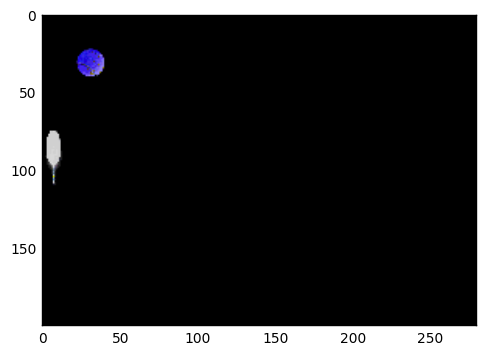

In [2]:
# red_screens = [get_channels_from_hex(s)[0] for s in screens]
plt.imshow(screens[0])
print("action:", actions[0])
print("score:", scores[0])
screens[0].shape

In [3]:
# Start with a simple MLP that takes two sequential screens and predicts the move
# based on some play history (probably a human player history)
# We're going to use 2 screens to give a sense of velocity to the neural network

# this is a really simple method that uses no reinforcement learning, and no convolutional nets

from functools import reduce
from keras.models import Sequential
from keras.layers import Dense

X = []
Y = []

for i in range(0, len(screens)-2, 2):
  screen1 = screens[i].flatten()
  screen2 = screens[i+1].flatten()
  two_screens = np.concatenate((screen1, screen2))
  X.append(two_screens)
  Y.append(actions[i + 1])

X = np.array(X)
Y = np.array(Y)

screen_pixels = reduce(lambda x, y: x*y, screens[0].shape)
input_dim = screen_pixels * 2

Using TensorFlow backend.


In [4]:
# make simple MLP model using keras
# by the way, if you have a small memory GPU this will blow it up


model = Sequential()
model.add(Dense(12, input_dim=input_dim, init='uniform', activation='relu'))
model.add(Dense(8, init='uniform', activation='relu'))
model.add(Dense(3, init='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, nb_epoch=5, batch_size=10)

model.save("saved_models/simple_MLP_supervised_weights.h5")

Epoch 1/5
132/132 [==============================] - 1s - loss: 0.6149 - acc: 0.7399     
Epoch 2/5
132/132 [==============================] - 1s - loss: 0.3046 - acc: 0.8864     
Epoch 3/5
132/132 [==============================] - 1s - loss: 0.2355 - acc: 0.9040     
Epoch 4/5
132/132 [==============================] - 1s - loss: 0.1869 - acc: 0.9167     
Epoch 5/5
132/132 [==============================] - 1s - loss: 0.1673 - acc: 0.9318     


In [5]:
# lets make an importable function that takes two screens and returns an
# output from the above simplistic model
# we can import this into a game play module and let the computer play
from keras.models import load_model

model = load_model("saved_models/simple_MLP_supervised_weights.h5")
def simple_computer_player(two_screens):
  action = model.predict(X[0, np.newaxis], batch_size=1, verbose=0)[0]
  return action

# here's an example of the simple_computer_player in action:
simple_computer_player(X[0])

array([ 0.00873377,  0.03249474,  0.91946584], dtype=float32)

In [6]:
# TODO, actually use reinforcement learning

# 1) train Q using basic Q learning update function on past history
# 2) play game using trained Q to epsilon greedily select the action with max Q value
# 3) repeat with step 1)